# Comparison of estimators
Several estimators are available in `sia`, depending on which type of model is being used.  For Linear/Gaussian models, `sia.KalmanFilter` estimator is optimal.  For Nonlinear/Gaussian, the `sia.ExtendedKalmanFilter` or `sia.ParticleFilter` suboptimal estimators can be used.  For a general user-implemented MarkovProcess, only the `sia.ParticleFilter` can be used.

| Estimator            | Optimal     | Supported models                                            |
| -------------------- | ----------- | ----------------------------------------------------------- |
| KalmanFilter         | Yes         | LinearGaussian, LinearGaussianCT                            |
| ExtendedKalmanFilter | No          | NonlinearGaussian, NonlinearGaussianCT, and linear Gaussian |
| ParticleFilter       | No          | MarkovProcess, and nonlinear/linear Gaussian                |

This example compares these algorithms to estimate the states of a linear/Gaussian model, since it is the most widely supported model type.  In practice, the `sia.KalmanFilter` should be used for this type of model.

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

To illustrate use of the estimator, we use an example from Crassidis and Junkins 2012, pp. 165, example 3.3.  The filter estimates flight attitude rate and bias error.  The state $x$ = (attitude, rate bias error), the input $u$ = (measured attitude rate), and the output is $y$ = (measured attitude).  The linear system is 
$$
x_k = \begin{pmatrix} 1 & -\Delta t \\ \Delta t & 0 \end{pmatrix} x_{k-1} 
 + \begin{pmatrix} \Delta t \\ 0 \end{pmatrix} u_k 
 + \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} w_k \\
y_k = \begin{pmatrix} 1 & 0 \end{pmatrix} x_k + v_k
$$
where $w_k \sim \mathcal{N}(0,Q)$ is process noise and $v_k \sim \mathcal{R}(0,R)$ is measurement noise, both determined via spectral power densities of the continuous time measurement.

In [2]:
dt = 1
sn = 17E-6
su = np.sqrt(10)*1E-10
sv = np.sqrt(10)*1E-7
q00 = sv**2 * dt + su**2 * dt**3 / 3
q01 = - su**2 * dt**2 / 2
q11 = su**2 * dt
r = sn**2
system = sia.LinearGaussian(
    F=np.array([[1, -dt], [0, 1]]),
    G=np.array([[dt], [0]]),
    C=np.array([[1, 0], [0, 1]]),
    H=np.array([[1, 0]]),
    Q=np.array([[q00, q01], [q01, q11]]),
    R=np.array([[r]]))

We initialize the estimators around the linear system.  The estimators must be initialized with a prior state, which for the Kalman filter and extended Kalman filter is a Gaussian belief.  For the particle filter, the prior is a particle belief.

In [3]:
# Initialize KF and EKF using a Gaussian prior
prior = sia.Gaussian(mean=np.array([0, 0]), covariance=np.diag([1E-4, 1E-12]))
kf = sia.KalmanFilter(system, state=prior)
ekf = sia.ExtendedKalmanFilter(system, state=prior)

# Initialize PF using a particle prior
particles = sia.Particles.init(prior, num_particles=1000)
pf = sia.ParticleFilter(system, particles=particles, resample_threshold=0.1, roughening_factor=0)

Use the `sia.Runner` class to simplify the task of simulating the system and performing the estimation step for a map/dictionary of estimators.  Internally, this class steps the dynamics model, samples a measurement, and then calls `estimate()` for each of the provided estimators.

In [4]:
# Initialize the runner with a buffer for n_steps
n_steps = 4000
estimators = {"kf": kf, "ekf": ekf, "pf": pf}
runner = sia.Runner(estimators, n_steps)

# Be sure to reset the filters explicitly before each new run
kf.reset(prior)
ekf.reset(prior)
pf.reset(particles)

# Initialize the ground truth state and step/estimate for n_steps
x = np.array([0, 4.8481e-7])
for k in range(0, n_steps):
    x = runner.stepAndEstimate(system, x, np.array([0.0011]))

We can access the recorder states via the `sia.Recorder` object.  Here we plot the state estimate error and 3$\sigma$ bounds recorded by the runner for each of the estimators.

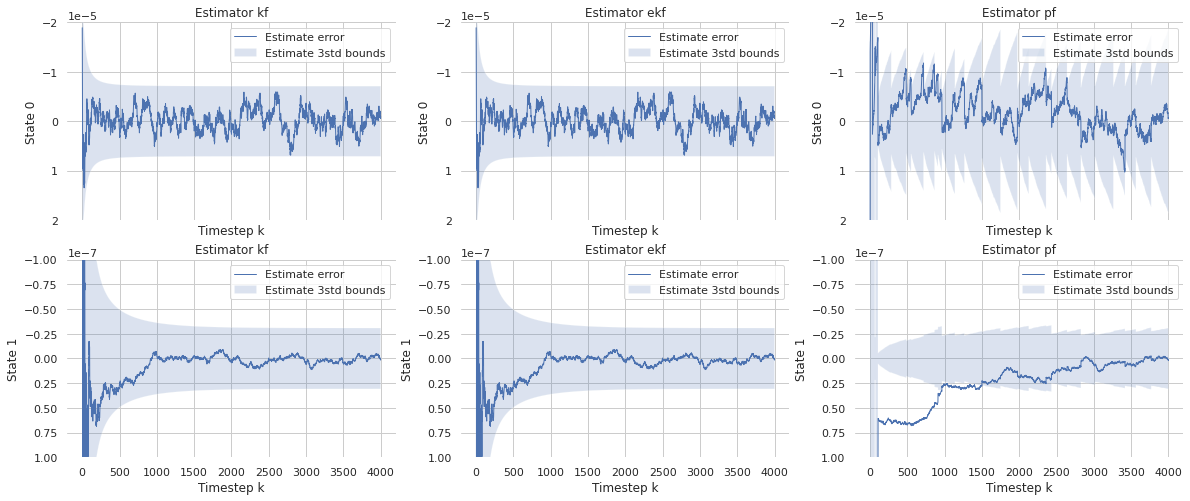

In [5]:
# Extract mean and covariance from buffer
recorder = runner.recorder()
x = recorder.getStates()
y = recorder.getObservations()

# Plot the recorded states
t = np.arange(0, n_steps, 1)
f, ax = plt.subplots(2, 3, sharex=True, figsize=(20, 8))
sns.despine(f, left=True, bottom=True)

ylim = np.array([[2e-5, -2e-5], [1e-7, -1e-7]])
for j in range(len(estimators)):
    name = list(estimators.keys())[j]
    xe_mu = recorder.getEstimateMeans(name)
    xe_var = recorder.getEstimateVariances(name)
    for i in range(2):
        plt.sca(ax[i, j])
        ax[i, j].fill_between(t,
                              -3 * np.sqrt(xe_var[i, :]),
                              +3 * np.sqrt(xe_var[i, :]),
                              alpha=0.2, label="Estimate 3std bounds")
        ax[i, j].plot(t, x[i, :] - xe_mu[i, :], lw=1, label="Estimate error")
        ax[i, j].legend()
        plt.ylim(ylim[i, :])
        plt.ylabel("State " + str(i))
        plt.xlabel("Timestep k")
        plt.title("Estimator " + name)
plt.show()